In [1]:
## Dependencies

import pandas as pd
import pathlib as path

import numpy as np
from scipy.stats import linregress

import matplotlib.pyplot as plt
import hvplot.pandas
import geopandas as gpd

import requests
import json
from pprint import pprint


## (1) CREATE DATA FRAME FOR DEATHS STATISTICS
    ## Daily data from 2020 to 2024
    # Resource : CSV file from World Health Organization 
        # https://data.who.int/dashboards/covid19/data?n=o

In [2]:
## create DataFrame death statistics

### import and read csv file

path_death = 'Resources/WHO-COVID-19-global-daily-data.csv'
death_df = pd.read_csv(path_death)

# death_df exploration

print(death_df.shape)
print(death_df.dtypes)
print(death_df.head())

(413760, 8)
Date_reported         object
Country_code          object
Country               object
WHO_region            object
New_cases            float64
Cumulative_cases       int64
New_deaths           float64
Cumulative_deaths      int64
dtype: object
  Date_reported Country_code     Country WHO_region  New_cases  \
0    2020-01-04           AI    Anguilla        AMR        NaN   
1    2020-01-04           AZ  Azerbaijan        EUR        NaN   
2    2020-01-04           BB    Barbados        AMR        NaN   
3    2020-01-04           BR      Brazil        AMR        NaN   
4    2020-01-04           BD  Bangladesh       SEAR        0.0   

   Cumulative_cases  New_deaths  Cumulative_deaths  
0                 0         NaN                  0  
1                 0         NaN                  0  
2                 0         NaN                  0  
3                 0         NaN                  0  
4                 0         0.0                  0  


In [3]:
### change data type for columns INT + date

death_df = death_df.astype({
    'Date_reported' : 'datetime64[ns]',
    'New_cases': "Float64", 
    'Cumulative_cases': "Float64", 
    'Cumulative_deaths' : 'Float64'
    })
death_df.dtypes

Date_reported        datetime64[ns]
Country_code                 object
Country                      object
WHO_region                   object
New_cases                   Float64
Cumulative_cases            Float64
New_deaths                  float64
Cumulative_deaths           Float64
dtype: object

In [4]:
death_df['year'] = death_df['Date_reported'].dt.year
death_df['month'] = death_df['Date_reported'].dt.month
death_df.head()

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,year,month
0,2020-01-04,AI,Anguilla,AMR,<NA>,0.0,NaN,0.0,2020,1
1,2020-01-04,AZ,Azerbaijan,EUR,<NA>,0.0,NaN,0.0,2020,1
2,2020-01-04,BB,Barbados,AMR,<NA>,0.0,NaN,0.0,2020,1
3,2020-01-04,BR,Brazil,AMR,<NA>,0.0,NaN,0.0,2020,1
4,2020-01-04,BD,Bangladesh,SEAR,0.0,0.0,0.0,0.0,2020,1


In [5]:
death_path = 'Output/output_deaths_data.csv'
death_df.to_csv(death_path)

In [6]:
### count of total cases and deaths by country GRoupBy

death_total_country = death_df.groupby('Country').agg({
    'Cumulative_cases' : 'max',
    'Cumulative_deaths' : 'max'
})
death_total_country
# death_total_country.sort_values(ascending=False)

,Cumulative_cases,Cumulative_deaths
Country,,
Afghanistan,235214.0,7998.0
Albania,335047.0,3605.0
Algeria,272170.0,6881.0
American Samoa,8359.0,34.0
Andorra,48015.0,159.0
...,...,...
Wallis and Futuna Is,3760.0,9.0
West Bank and Gaza Strip,703228.0,5708.0
Yemen,11945.0,2159.0


In [ ]:
# ### add column total_cases + total_death for each country

# death_df_clean = pd.merge(death_df,death_total_country,on='Country')

# death_df_clean

In [ ]:
# ### rename new columns 

# death_df_clean = death_df_clean.rename(columns={
#     'Cumulative_deaths_x' : 'Cumulative_deaths',
#     'Cumulative_deaths_y' : "Total_deaths",
#     'Cumulative_cases_x' : 'Cumulative_cases',
#     'Cumulative_cases_y' : "Total_cases"
# })
# death_df_clean

# (2) CREATE DATAFRAME FOR VACCINATION STATISTICS
    # Statistic end of period (static)
    # same source WHO :  https://data.who.int/dashboards/covid19/data?n=o

In [7]:
## create DataFrame Vaccination 

## Import and read csv file

path_Vaccination = 'Resources/vaccination-data.csv'
Vaccination_df = pd.read_csv(path_Vaccination)

# Vaccination _df exploration

print(Vaccination_df.shape)
print(Vaccination_df.dtypes)
print(Vaccination_df.head())

(215, 16)
COUNTRY                                  object
ISO3                                     object
WHO_REGION                               object
DATA_SOURCE                              object
DATE_UPDATED                             object
TOTAL_VACCINATIONS                      float64
PERSONS_VACCINATED_1PLUS_DOSE           float64
TOTAL_VACCINATIONS_PER100               float64
PERSONS_VACCINATED_1PLUS_DOSE_PER100    float64
PERSONS_LAST_DOSE                       float64
PERSONS_LAST_DOSE_PER100                float64
VACCINES_USED                           float64
FIRST_VACCINE_DATE                       object
NUMBER_VACCINES_TYPES_USED              float64
PERSONS_BOOSTER_ADD_DOSE                float64
PERSONS_BOOSTER_ADD_DOSE_PER100         float64
dtype: object
       COUNTRY ISO3 WHO_REGION DATA_SOURCE DATE_UPDATED  TOTAL_VACCINATIONS  \
0        Aruba  ABW       AMRO   REPORTING   2023-12-29            217124.0   
1  Afghanistan  AFG       EMRO   REPORTING   2023-

In [8]:
## change data type for columns INT + date

Vaccination_df = Vaccination_df.astype({
    'DATE_UPDATED' : 'datetime64[ns]',
    'FIRST_VACCINE_DATE' : 'datetime64[ns]'
    })
Vaccination_df.dtypes

COUNTRY                                         object
ISO3                                            object
WHO_REGION                                      object
DATA_SOURCE                                     object
DATE_UPDATED                            datetime64[ns]
TOTAL_VACCINATIONS                             float64
PERSONS_VACCINATED_1PLUS_DOSE                  float64
TOTAL_VACCINATIONS_PER100                      float64
PERSONS_VACCINATED_1PLUS_DOSE_PER100           float64
PERSONS_LAST_DOSE                              float64
PERSONS_LAST_DOSE_PER100                       float64
VACCINES_USED                                  float64
FIRST_VACCINE_DATE                      datetime64[ns]
NUMBER_VACCINES_TYPES_USED                     float64
PERSONS_BOOSTER_ADD_DOSE                       float64
PERSONS_BOOSTER_ADD_DOSE_PER100                float64
dtype: object

## Create 1 DataFrame : Deaths + Vaccination statistics
    ## Merge 2 previous DF

In [9]:
##  merge DF death + vaccination

death_vaccins_df = pd.merge(
    Vaccination_df,
    death_total_country,
    how="inner",
    left_on = 'COUNTRY',
    right_on = 'Country'
    )

death_vaccins_df.head()


,COUNTRY,ISO3,WHO_REGION,DATA_SOURCE,DATE_UPDATED,TOTAL_VACCINATIONS,PERSONS_VACCINATED_1PLUS_DOSE,TOTAL_VACCINATIONS_PER100,PERSONS_VACCINATED_1PLUS_DOSE_PER100,PERSONS_LAST_DOSE,PERSONS_LAST_DOSE_PER100,VACCINES_USED,FIRST_VACCINE_DATE,NUMBER_VACCINES_TYPES_USED,PERSONS_BOOSTER_ADD_DOSE,PERSONS_BOOSTER_ADD_DOSE_PER100,Cumulative_cases,Cumulative_deaths
0,Aruba,ABW,AMRO,REPORTING,2023-12-29,217124.0,90493.0,203.0,85.0,84363.0,79.0,NaN,2021-02-17,NaN,35659.0,33.0,44224.0,292.0
1,Afghanistan,AFG,EMRO,REPORTING,2023-12-31,22964750.0,19151369.0,59.0,49.0,18370386.0,47.0,NaN,2021-02-22,NaN,2729940.0,7.0,235214.0,7998.0
2,Angola,AGO,AFRO,REPORTING,2023-12-31,27819132.0,16550642.0,85.0,50.0,9609080.0,29.0,NaN,2021-03-10,NaN,3067091.0,9.0,107481.0,1937.0
3,Anguilla,AIA,AMRO,REPORTING,2023-12-29,24864.0,10858.0,166.0,72.0,10382.0,69.0,NaN,2021-02-05,NaN,3231.0,22.0,3904.0,12.0
4,Albania,ALB,EURO,REPORTING,2023-12-23,3088966.0,1349255.0,107.0,47.0,1279333.0,44.0,NaN,2021-01-13,NaN,402371.0,14.0,335047.0,3605.0


In [10]:
# explore columns

print(death_vaccins_df.columns)

Index(['COUNTRY', 'ISO3', 'WHO_REGION', 'DATA_SOURCE', 'DATE_UPDATED',
       'TOTAL_VACCINATIONS', 'PERSONS_VACCINATED_1PLUS_DOSE',
       'TOTAL_VACCINATIONS_PER100', 'PERSONS_VACCINATED_1PLUS_DOSE_PER100',
       'PERSONS_LAST_DOSE', 'PERSONS_LAST_DOSE_PER100', 'VACCINES_USED',
       'FIRST_VACCINE_DATE', 'NUMBER_VACCINES_TYPES_USED',
       'PERSONS_BOOSTER_ADD_DOSE', 'PERSONS_BOOSTER_ADD_DOSE_PER100',
       'Cumulative_cases', 'Cumulative_deaths'],
      dtype='object')


In [11]:
# selected useful columns for death_vaccins_df 

death_vaccins_df_clean = death_vaccins_df[['COUNTRY', 'ISO3', 'WHO_REGION', 'DATA_SOURCE', 'DATE_UPDATED',       
        'TOTAL_VACCINATIONS', 'PERSONS_VACCINATED_1PLUS_DOSE',
       'TOTAL_VACCINATIONS_PER100', 'PERSONS_VACCINATED_1PLUS_DOSE_PER100',
       'PERSONS_LAST_DOSE', 'PERSONS_LAST_DOSE_PER100', 'VACCINES_USED',
       'FIRST_VACCINE_DATE', 'NUMBER_VACCINES_TYPES_USED',
       'PERSONS_BOOSTER_ADD_DOSE', 'PERSONS_BOOSTER_ADD_DOSE_PER100',
       'Cumulative_cases', 'Cumulative_deaths'
        ]]

death_vaccins_df_clean = death_vaccins_df_clean.rename(columns={'ISO3':'country_ID'})
death_vaccins_df_clean.head()

,COUNTRY,country_ID,WHO_REGION,DATA_SOURCE,DATE_UPDATED,TOTAL_VACCINATIONS,PERSONS_VACCINATED_1PLUS_DOSE,TOTAL_VACCINATIONS_PER100,PERSONS_VACCINATED_1PLUS_DOSE_PER100,PERSONS_LAST_DOSE,PERSONS_LAST_DOSE_PER100,VACCINES_USED,FIRST_VACCINE_DATE,NUMBER_VACCINES_TYPES_USED,PERSONS_BOOSTER_ADD_DOSE,PERSONS_BOOSTER_ADD_DOSE_PER100,Cumulative_cases,Cumulative_deaths
0,Aruba,ABW,AMRO,REPORTING,2023-12-29,217124.0,90493.0,203.0,85.0,84363.0,79.0,NaN,2021-02-17,NaN,35659.0,33.0,44224.0,292.0
1,Afghanistan,AFG,EMRO,REPORTING,2023-12-31,22964750.0,19151369.0,59.0,49.0,18370386.0,47.0,NaN,2021-02-22,NaN,2729940.0,7.0,235214.0,7998.0
2,Angola,AGO,AFRO,REPORTING,2023-12-31,27819132.0,16550642.0,85.0,50.0,9609080.0,29.0,NaN,2021-03-10,NaN,3067091.0,9.0,107481.0,1937.0
3,Anguilla,AIA,AMRO,REPORTING,2023-12-29,24864.0,10858.0,166.0,72.0,10382.0,69.0,NaN,2021-02-05,NaN,3231.0,22.0,3904.0,12.0
4,Albania,ALB,EURO,REPORTING,2023-12-23,3088966.0,1349255.0,107.0,47.0,1279333.0,44.0,NaN,2021-01-13,NaN,402371.0,14.0,335047.0,3605.0


In [12]:
### little check

print(death_vaccins_df_clean.shape)
print(death_vaccins_df_clean.columns)

(204, 18)
Index(['COUNTRY', 'country_ID', 'WHO_REGION', 'DATA_SOURCE', 'DATE_UPDATED',
       'TOTAL_VACCINATIONS', 'PERSONS_VACCINATED_1PLUS_DOSE',
       'TOTAL_VACCINATIONS_PER100', 'PERSONS_VACCINATED_1PLUS_DOSE_PER100',
       'PERSONS_LAST_DOSE', 'PERSONS_LAST_DOSE_PER100', 'VACCINES_USED',
       'FIRST_VACCINE_DATE', 'NUMBER_VACCINES_TYPES_USED',
       'PERSONS_BOOSTER_ADD_DOSE', 'PERSONS_BOOSTER_ADD_DOSE_PER100',
       'Cumulative_cases', 'Cumulative_deaths'],
      dtype='object')


In [13]:
## Export to CSV

death_vaccins_path = 'Output/output_death_vaccination_data.csv'
death_vaccins_df_clean.to_csv(death_vaccins_path)

## (3) Extract the official referential of Countries used by the World Bank
    # OUtput file CSV availabe in directory Resources
    # source API World Bank
        ### this code should / must be runned once (no need to update the file)
        ## will be used below to extract data (GDP + population)
        ## can be used for different other requests

In [2]:
## retrieve all the countries in API

### generate DF Countries

page = 1   ## there are 6 pages in the json file
data = []
url_countries = 'https://api.worldbank.org/v2/country?format=json'

for page in range(1,7):
    response = requests.get(f"{url_countries}&page={page}")
    json_data = response.json()
    
    # Add the data from the current page
    data.extend(json_data[1])  
    



## create DF and select columns

countries_df = pd.DataFrame(data)
countries_df['region'] = countries_df['region'].apply(lambda x: x['value'])
countries_df = countries_df[['id', 'iso2Code', 'name', 'region','capitalCity', 'longitude', 'latitude']]

countries_df.head()

NameError: name 'requests' is not defined

In [15]:
### TO RUN ONLY ONCE
### Export to csv file

country_path = 'Output/output_countries_list_who_referential.csv'
countries_df.to_csv(country_path)

In [16]:
countries_df.columns

Index(['id', 'iso2Code', 'name', 'region', 'capitalCity', 'longitude',
       'latitude'],
      dtype='object')

# (4) CREATE DataFrame WITH GDP_perCapita & POPULATION DATA FOR EACH COUNTRY
    # data from 2019 to 2020
    # collect : GDp per Capita + Population
    # From Worldbank API (2 different APi end points)
    #
    # generates 2 different DF which will be merged and cleaned
    # output csv file available in directory Output 

In [17]:
print(f"start code")
print('---------------------------')

## create list of countries from previous DF

country_list = countries_df['id'].tolist()

gdp_list = []
pop_list = []

# indicator = ['NY.GDP.PCAP.CD','SP.POP.TOT']

# each country has its onwn end Point, so need to loop through all end points and extract needed data

for id in country_list :

    print(f"--------------------------")
    print(f"country {id}")

    ## collect data for GDP

    try:  

       

        link_gdp = f'https://api.worldbank.org/v2/country/{id}/indicator/NY.GDP.PCAP.CD?date=2019:2023&format=json'
        response_gdp = requests.get(link_gdp).json()

        # pprint(response_gdp)

        gdp_list.append({
            'country_ID' : response_gdp[1][0]['countryiso3code'],
            'country_ID_2' : response_gdp[1][0]['country']['id'],
            'country_name' : response_gdp[1][0]['country']['value'],
            'GDPcap_2023' : response_gdp[1][0]['value'] ,
            'GDPcap_2022' : response_gdp[1][1]['value'] ,
            'GDPcap_2021' : response_gdp[1][2]['value'] ,
            'GDPcap_2020' : response_gdp[1][3]['value'],
            'GDPcap_2019' : response_gdp[1][4]['value']
            })
        

    except: 
        print("Country not found GDP. Skipping...")

    ## collect data for Population

    try:

        link_pop = f'https://api.worldbank.org/v2/country/{id}/indicator/SP.POP.TOTL?date=2019:2023&format=json'
        response_pop = requests.get(link_pop).json()

        # pprint(response_pop)

        pop_list.append({
            'country_ID' : response_pop[1][0]['countryiso3code'],
            'country_ID_2' : response_pop[1][0]['country']['id'],
            'country_name' : response_pop[1][0]['country']['value'],              
            'pop_2023' : response_pop[1][0]['value'] ,
            'pop_2022' :response_pop[1][1]['value'] ,
            'pop_2021' :response_pop[1][2]['value'] ,
            'pop_2020' : response_pop[1][3]['value'],
            'pop_2019' : response_pop[1][4]['value']
            })
    except:   
        print("Country not found POP. Skipping...")

start code
---------------------------
--------------------------
country ABW
--------------------------
country AFE
--------------------------
country AFG
--------------------------
country AFR
Country not found GDP. Skipping...
Country not found POP. Skipping...
--------------------------
country AFW
--------------------------
country AGO
--------------------------
country ALB
--------------------------
country AND
--------------------------
country ARB
--------------------------
country ARE
--------------------------
country ARG
--------------------------
country ARM
--------------------------
country ASM
--------------------------
country ATG
--------------------------
country AUS
--------------------------
country AUT
--------------------------
country AZE
--------------------------
country BDI
--------------------------
country BEA
Country not found GDP. Skipping...
Country not found POP. Skipping...
--------------------------
country BEC
Country not found GDP. Skipping...
Countr

In [18]:
## Create DF

gdp_df = pd.DataFrame(gdp_list)
pop_df = pd.DataFrame(pop_list)


## Merge to create gdp_pop_df

gdp_pop_df = pd.merge(gdp_df,pop_df,on='country_ID')

## Rename and select columns

gdp_pop_df = gdp_pop_df.drop(columns={
                                    'country_name_y',
                                    'country_ID_2_y'
                                    })
gdp_pop_df = gdp_pop_df.rename(columns={
                                    'country_name_x' : 'country_name',
                                    'country_ID_2_x' : 'country_ID_2'
                                    })

gdp_pop_df = gdp_pop_df.dropna(how='all')


gdp_pop_df.head()

,country_ID,country_ID_2,country_name,GDPcap_2023,GDPcap_2022,GDPcap_2021,GDPcap_2020,GDPcap_2019,pop_2023,pop_2022,pop_2021,pop_2020,pop_2019
0,ABW,AW,Aruba,NaN,33300.838819,29127.759384,24008.127822,31902.809818,106277.0,106445.0,106537.0,106585.0,106442.0
1,AFE,ZH,Africa Eastern and Southern,1672.505957,1642.432039,1545.956697,1356.088871,1508.486886,739108306.0,720859132.0,702977106.0,685112979.0,667242986.0
2,AFG,AF,Afghanistan,NaN,352.603733,355.777826,512.055098,497.741431,42239854.0,41128771.0,40099462.0,38972230.0,37769499.0
3,AFW,ZI,Africa Western and Central,1584.333285,1788.875347,1769.171853,1688.470871,1813.609146,502789511.0,490330870.0,478185907.0,466189102.0,454306063.0
4,AGO,AO,Angola,2309.521620,2933.484644,1927.474078,1450.905111,2191.347764,36684202.0,35588987.0,34503774.0,33428486.0,32353588.0


In [19]:
## Export to CSV file 

gdp_pop_path = 'Output/output_countries_gdp_pop.csv'
gdp_pop_df.to_csv(gdp_pop_path)

# (5) create a DF with full data covid
    # vacination + deaths + GDP + population
    # add coordinate from Coutries DF
    # export to csv

In [20]:
## MERGE death_vaccins_df_clean WITH gdp_pop_df
## create fields to be analysed 

data_covid_macro = pd.merge(
                            death_vaccins_df_clean,
                            gdp_pop_df,
                            how='left',
                            right_on= "country_ID",
                            left_on=  'country_ID'
                            )

# add coordinate
data_covid_macro = pd.merge(data_covid_macro,
                            countries_df,
                            left_on ='country_ID',
                            right_on ='id',
                            how='left')

data_covid_macro = data_covid_macro.drop(columns={'id','iso2Code','region','name','capitalCity'})

data_covid_macro.head()

,COUNTRY,country_ID,WHO_REGION,DATA_SOURCE,DATE_UPDATED,TOTAL_VACCINATIONS,PERSONS_VACCINATED_1PLUS_DOSE,TOTAL_VACCINATIONS_PER100,PERSONS_VACCINATED_1PLUS_DOSE_PER100,PERSONS_LAST_DOSE,...,GDPcap_2021,GDPcap_2020,GDPcap_2019,pop_2023,pop_2022,pop_2021,pop_2020,pop_2019,longitude,latitude
0,Aruba,ABW,AMRO,REPORTING,2023-12-29,217124.0,90493.0,203.0,85.0,84363.0,...,29127.759384,24008.127822,31902.809818,106277.0,106445.0,106537.0,106585.0,106442.0,-70.0167,12.5167
1,Afghanistan,AFG,EMRO,REPORTING,2023-12-31,22964750.0,19151369.0,59.0,49.0,18370386.0,...,355.777826,512.055098,497.741431,42239854.0,41128771.0,40099462.0,38972230.0,37769499.0,69.1761,34.5228
2,Angola,AGO,AFRO,REPORTING,2023-12-31,27819132.0,16550642.0,85.0,50.0,9609080.0,...,1927.474078,1450.905111,2191.347764,36684202.0,35588987.0,34503774.0,33428486.0,32353588.0,13.242,-8.81155
3,Anguilla,AIA,AMRO,REPORTING,2023-12-29,24864.0,10858.0,166.0,72.0,10382.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Albania,ALB,EURO,REPORTING,2023-12-23,3088966.0,1349255.0,107.0,47.0,1279333.0,...,6377.203096,5343.037704,5396.214243,2745972.0,2777689.0,2811666.0,2837849.0,2854191.0,19.8172,41.3317


In [21]:
## Export to CSV file 

data_covid_macro_path = 'Output/output_covid_data_macro.csv'
data_covid_macro.to_csv(data_covid_macro_path)

## Analysis

In [22]:
data1 = data_covid_macro[[
                     "COUNTRY",'country_ID',
                     'TOTAL_VACCINATIONS', 'Cumulative_deaths','pop_2023',
                     'GDPcap_2023','GDPcap_2022','GDPcap_2019',
                     'longitude', 'latitude'
                    ]]


data1

,COUNTRY,country_ID,TOTAL_VACCINATIONS,Cumulative_deaths,pop_2023,GDPcap_2023,GDPcap_2022,GDPcap_2019,longitude,latitude
0,Aruba,ABW,217124.0,292.0,106277.0,NaN,33300.838819,31902.809818,-70.0167,12.5167
1,Afghanistan,AFG,22964750.0,7998.0,42239854.0,NaN,352.603733,497.741431,69.1761,34.5228
2,Angola,AGO,27819132.0,1937.0,36684202.0,2309.521620,2933.484644,2191.347764,13.242,-8.81155
3,Anguilla,AIA,24864.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN
4,Albania,ALB,3088966.0,3605.0,2745972.0,8367.775731,6810.114041,5396.214243,19.8172,41.3317
...,...,...,...,...,...,...,...,...,...,...
199,Tonga,TON,204737.0,13.0,107773.0,NaN,4681.679407,4878.978686,-175.216,-21.136
200,Tuvalu,TUV,26783.0,1.0,11396.0,5465.102807,5221.533070,4940.050983,179.089567,-8.6314877
201,Viet Nam,VNM,266492149.0,43206.0,98858950.0,4346.768492,4179.011790,3491.091410,105.825,21.0069
202,Vanuatu,VUT,355430.0,14.0,334506.0,3367.094639,3128.540422,3076.589886,168.321,-17.7404


In [23]:
## calculate vaccination %

data1['Vaccination_%'] = data1['TOTAL_VACCINATIONS']*100/data1['pop_2023']

## calculate deaths/population %

data1['death_%'] = data1['Cumulative_deaths']*100/data1['pop_2023']

## calculate growth per capita % (if gdp2023 = Nan, replace with 2022 data)

data1['Grwth'] = np.where(data1['GDPcap_2023'].notna(),
    (data1['GDPcap_2023']-data1['GDPcap_2019'])*100/(data1['GDPcap_2019']*4),
    (data1['GDPcap_2022']-data1['GDPcap_2019'])*100/(data1['GDPcap_2019']*3)
    )

## drop empty cells / rows
data1 = data1.dropna(how='any')

## convert Latitude + Longitude to Float
data1 = data1.astype({
            'longitude' : "float",
            'latitude' : "float"
            })

data1

C:\Users\nazim\AppData\Local\Temp\ipykernel_19124\3922945541.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['Vaccination_%'] = data1['TOTAL_VACCINATIONS']*100/data1['pop_2023']
C:\Users\nazim\AppData\Local\Temp\ipykernel_19124\3922945541.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['death_%'] = data1['Cumulative_deaths']*100/data1['pop_2023']
C:\Users\nazim\AppData\Local\Temp\ipykernel_19124\3922945541.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

,COUNTRY,country_ID,TOTAL_VACCINATIONS,Cumulative_deaths,pop_2023,GDPcap_2023,GDPcap_2022,GDPcap_2019,longitude,latitude,Vaccination_%,death_%,Grwth
2,Angola,AGO,27819132.0,1937.0,36684202.0,2309.521620,2933.484644,2191.347764,13.242000,-8.811550,75.834093,0.00528,5.392748
4,Albania,ALB,3088966.0,3605.0,2745972.0,8367.775731,6810.114041,5396.214243,19.817200,41.331700,112.490805,0.131283,55.067522
5,Andorra,AND,157072.0,159.0,80088.0,46544.720720,42350.697069,41328.600498,1.521800,42.507500,196.124263,0.198532,12.621091
6,Argentina,ARG,116686617.0,130678.0,46654581.0,13730.514709,13650.604629,9963.674162,-58.417300,-34.611800,250.107523,0.280097,37.805738
7,Armenia,ARM,2256919.0,8777.0,2777970.0,8715.765336,7018.051504,4828.504886,44.509000,40.159600,81.243462,0.31595,80.506503
...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,Timor-Leste,TLS,2028798.0,138.0,1360596.0,1648.647290,2389.295875,1583.078603,125.567000,-8.566670,149.110978,0.010143,4.141847
200,Tuvalu,TUV,26783.0,1.0,11396.0,5465.102807,5221.533070,4940.050983,179.089567,-8.631488,235.021060,0.008775,10.628470
201,Viet Nam,VNM,266492149.0,43206.0,98858950.0,4346.768492,4179.011790,3491.091410,105.825000,21.006900,269.568055,0.043705,24.510303
202,Vanuatu,VUT,355430.0,14.0,334506.0,3367.094639,3128.540422,3076.589886,168.321000,-17.740400,106.255194,0.004185,9.442427


In [24]:
data1.dtypes

COUNTRY                object
country_ID             object
TOTAL_VACCINATIONS    float64
Cumulative_deaths     Float64
pop_2023              float64
GDPcap_2023           float64
GDPcap_2022           float64
GDPcap_2019           float64
longitude             float64
latitude              float64
Vaccination_%         float64
death_%               Float64
Grwth                 float64
dtype: object

C:\Users\nazim\AppData\Local\Temp\ipykernel_19124\2013106357.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data1_dict.values(),labels=data1_dict.keys())


<function matplotlib.pyplot.show(close=None, block=None)>

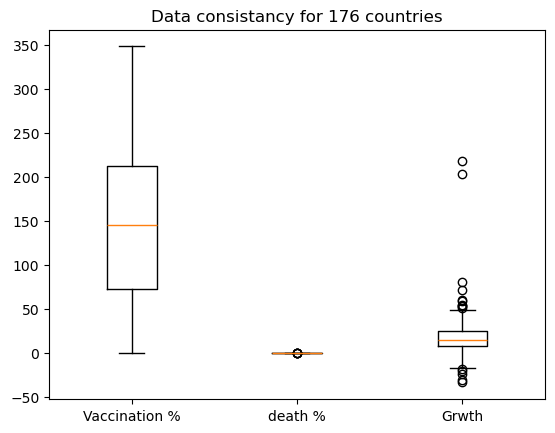

In [25]:
## identify outlayers

lenth = len(data1['COUNTRY'])

data1_dict = {
    'Vaccination %': data1['Vaccination_%'],
    'death %' : data1['death_%'],
    'Grwth' : data1['Grwth']
    }

plt.boxplot(data1_dict.values(),labels=data1_dict.keys())
plt.title(f'Data consistancy for {lenth} countries')

plt.savefig("Output/boxplots.png")
plt.show

In [26]:
## % death in the world
# %%capture --no-display

Lat = data1['latitude']
Lng = data1['longitude']

world_map_death = data1.hvplot.points('longitude',
                                      'latitude',
                                      geo=True,
                                      tiles=True, 
                                      color='COUNTRY', 
                                      alpha=0.9,
                                      frame_width = 700,
                                      frame_height = 500,
                                      size = 'death %',
                                      cmap='Category10'
)
world_map_death                                 

c:\Users\nazim\anaconda3\envs\virt_env_mod6\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [longitude,latitude]   (COUNTRY)

C:\Users\nazim\AppData\Local\Temp\ipykernel_19124\1922392171.py:10: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


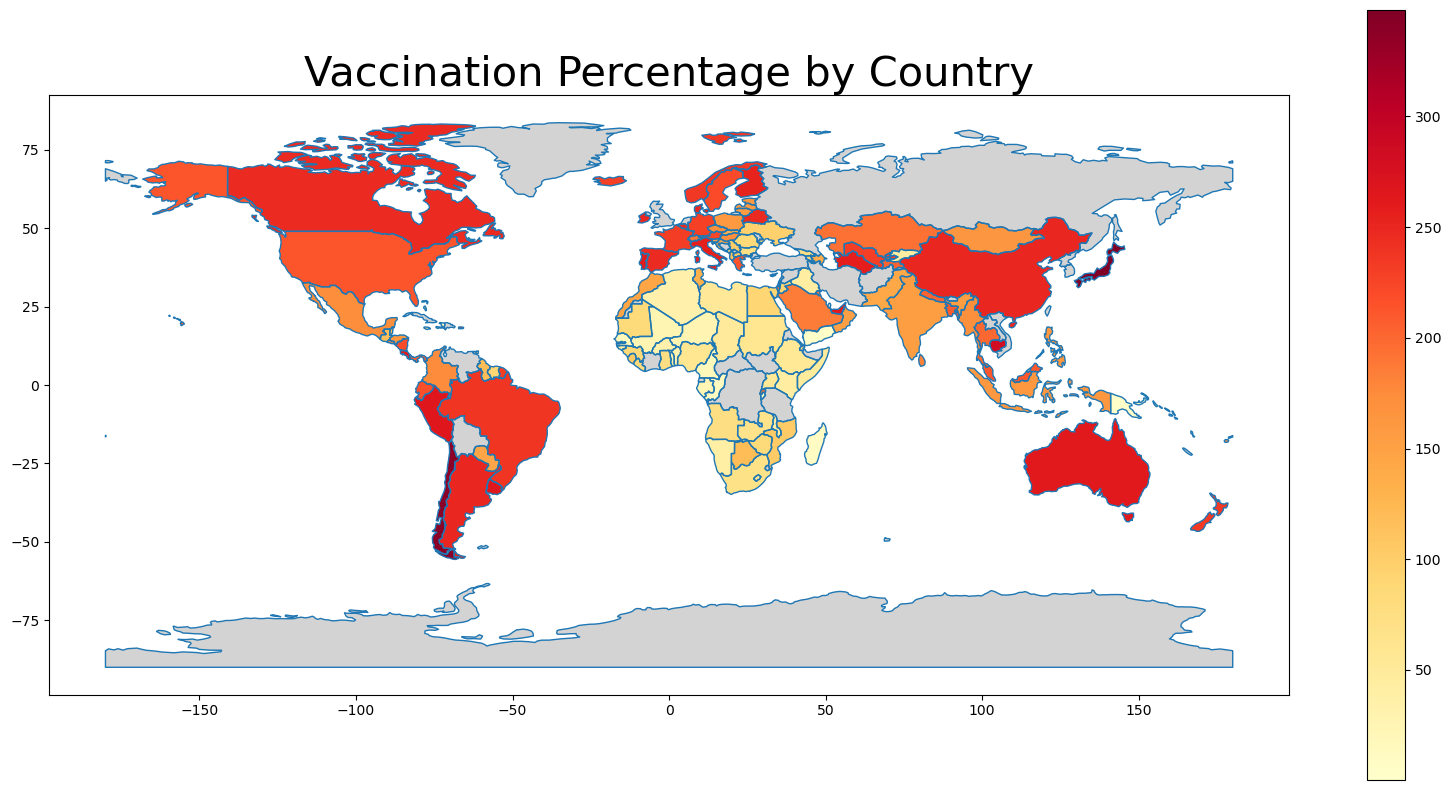

In [27]:
## Create a world map with Vaccination %
#  
# Sample data: replace this with your actual DataFrame
data = pd.DataFrame({
    'COUNTRY': data1['COUNTRY'],  # Replace with your country names
    'vaccination': data1['Vaccination_%']  # Replace with your actual data
})

# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the GeoDataFrame with your data
world = world.merge(data, how="left", left_on="name", right_on="COUNTRY")

# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
world.boundary.plot(ax=ax, linewidth=1)
world.plot(column='vaccination', ax=ax, legend=True,
           cmap='YlOrRd', missing_kwds={"color": "lightgrey"})

plt.title('Vaccination Percentage by Country', fontsize = 30)
plt.savefig("Output/Vaccination_perc_worlwide.png")

plt.show()

C:\Users\nazim\AppData\Local\Temp\ipykernel_19124\2735916790.py:10: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


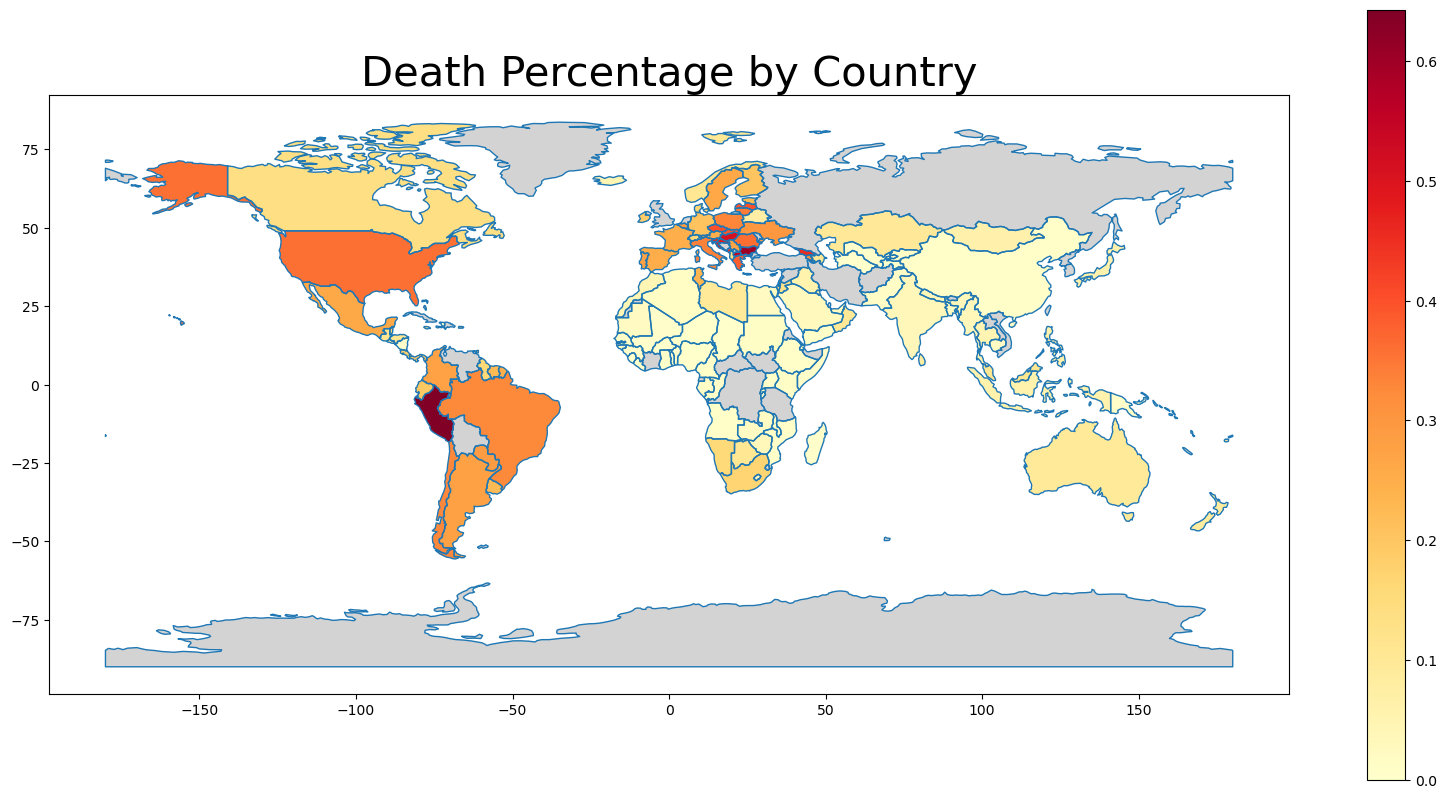

In [28]:
## Create a world map with death %
#  
# Sample data: replace this with your actual DataFrame
data = pd.DataFrame({
    'COUNTRY': data1['COUNTRY'],  # Replace with your country names
    'death_percentage': data1['death_%']  # Replace with your actual data
})

# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the GeoDataFrame with your data
world = world.merge(data, how="left", left_on="name", right_on="COUNTRY")

# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
world.boundary.plot(ax=ax, linewidth=1)
world.plot(column='death_percentage', ax=ax, legend=True,
           cmap='YlOrRd', missing_kwds={"color": "lightgrey"})

plt.title('Death Percentage by Country', fontsize = 30)
plt.savefig("Output/death_perc_worlwide.png")

plt.show()

C:\Users\nazim\AppData\Local\Temp\ipykernel_19124\2979704971.py:10: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


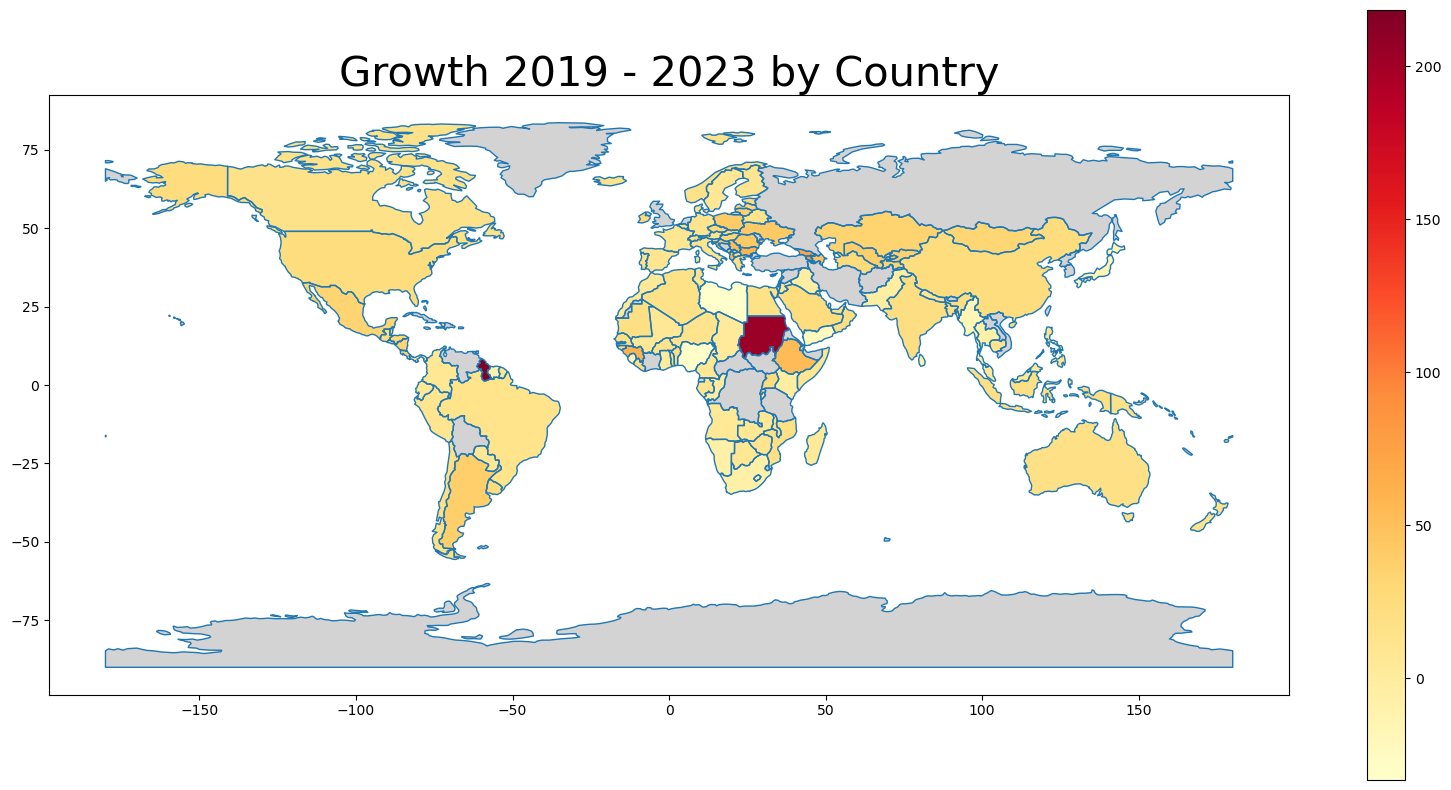

In [29]:
## Create a world map with Growth %
#  
# Sample data: replace this with your actual DataFrame
data = pd.DataFrame({
    'COUNTRY': data1['COUNTRY'],  # Replace with your country names
    'Growth': data1['Grwth']  # Replace with your actual data
})

# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the GeoDataFrame with your data
world = world.merge(data, how="left", left_on="name", right_on="COUNTRY")

# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
world.boundary.plot(ax=ax, linewidth=1)
world.plot(column='Growth', ax=ax, legend=True,
           cmap='YlOrRd', missing_kwds={"color": "lightgrey"})

plt.title('Growth 2019 - 2023 by Country', fontsize = 30)
plt.savefig("Output/Growth_perc_worlwide.png")
plt.show()

## define function to create regression plot

In [43]:
def regression_plot(dataframe, col1, col2):

    x_axis = dataframe[col1]
    y_axis = dataframe[col2]

    ## calculate slope and intercept of the regression equation

    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
    
    #print the r-value

    print(f' The r^value is : {round(rvalue,3)}')

    ### generate the equation to be used as annotation
    
    regress_values = x_axis * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

    ## generate the regression line plot 

    plt.scatter(x_axis,y_axis)
    plt.plot(x_axis,regress_values,"r-")

    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.title(f'{col1} vs {col2}')

    ## Conditional Annotation position

    if slope >= 0 :
        x_annot_pos = 0.05
        y_annot_pos = 0.9
    else : x_annot_pos, y_annot_pos = 0.05, 0.1

    plt.annotate(line_eq,(x_annot_pos,y_annot_pos), fontsize=12,color="red", xycoords='axes fraction')

    plt.savefig(f'Output/regression_{col1}_vs_{col2}.png')
    plt.show()

 The r^value is : -0.036


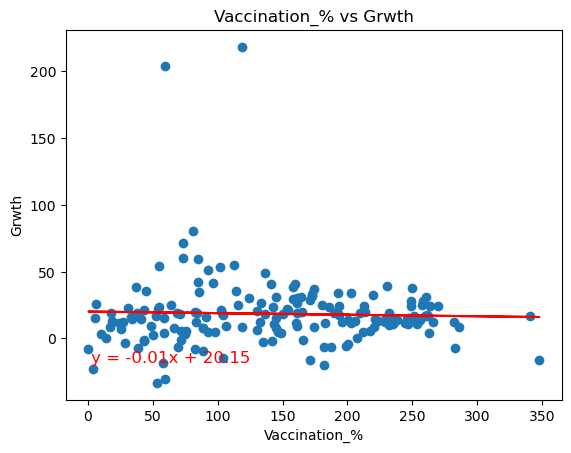

In [44]:
# Build scatter plot for vaccination vs Growth

regression_plot(data1,'Vaccination_%', 'Grwth')

 The r^value is : 0.205


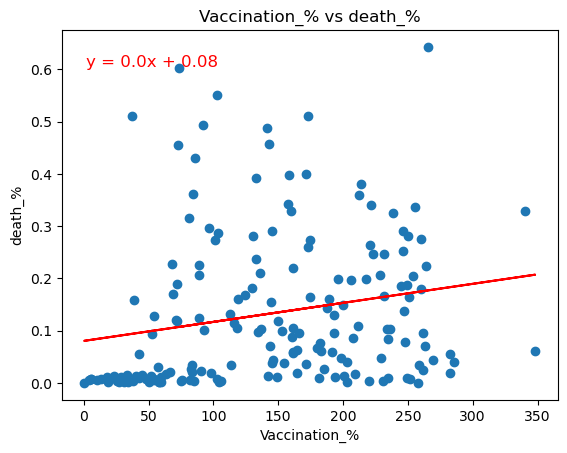

In [45]:
# Build scatter plot for vaccination vs deaths

regression_plot(data1,'Vaccination_%', 'death_%')

 The r^value is : 0.219


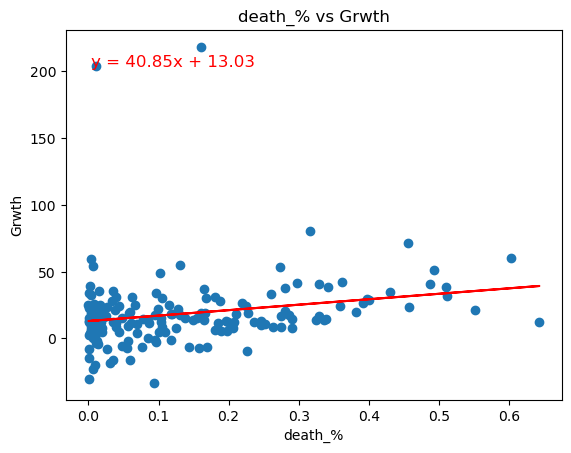

In [47]:
# Build scatter plot for death vs Growth

regression_plot(data1,'death_%', 'Grwth')

# Codes not to be used except to test the API's

In [ ]:
# link_pop = 'https://api.worldbank.org/v2/country/ABW/indicator/SP.POP.TOTL?date=2020:2023&format=json'
           
# response_pop = requests.get(link_pop).json()

# # pprint(response_pop)

# print(f'country ID ={response_pop[1][0]['country']['id']}')
# print(f'country ID ={response_pop[1][0]['country']['value']}')
# print(f'pop_2023 ={response_pop[1][0]['value']}')
# print(f'pop_2022 ={response_pop[1][1]['value']}')
# print(f'pop_2021 ={response_pop[1][2]['value']}')
# print(f'pop_2020 ={response_pop[1][3]['value']}')

In [1]:
link_gdp = f'https://api.worldbank.org/v2/country/ABW/indicator/NY.GDP.PCAP.CD?date=2019:2023&format=json'

link_gdp
response_gdp = requests.get(link_gdp).json()

response_gdp
pprint(response_gdp)


print(f'country ID ={response_gdp[1][0]['country']['id']}')
print(f'country ID ={response_gdp[1][0]['countryiso3code']}')
print(f'country ID_2 ={response_gdp[1][0]['country']['value']}')
print(f'GDP_2023 ={response_gdp[1][0]['value']}')
print(f'GDP_2022 ={response_gdp[1][1]['value']}')
print(f'GDP_2021 ={response_gdp[1][2]['value']}')
print(f'GDP_2020 ={response_gdp[1][3]['value']}')
print(f'GDP_2019 ={response_gdp[1][4]['value']}')

NameError: name 'requests' is not defined